<font color=White size=5 face=雅黑>1 Generative adversarial network</font>

<font color=White size=4 face=雅黑>1. Construct a DCGAN with GAN objective, you can refer to the tutorial website provided
by PyTorch for implementation.</font>


In [22]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [23]:
# Root directory for dataset
dataroot = "/Users/ASUS/Desktop/課程文件/深度學習/DL_HW2/hw2_0810529_1/VAE_dataset/"
# Number of workers for dataloader
workers = 0
# Batch size during training
batch_size = 128
# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64
# Number of channels in the training images. For color images this is 3
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
# Number of training epochs
num_epochs = 100
# Learning rate for optimizers
lr = 0.0002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

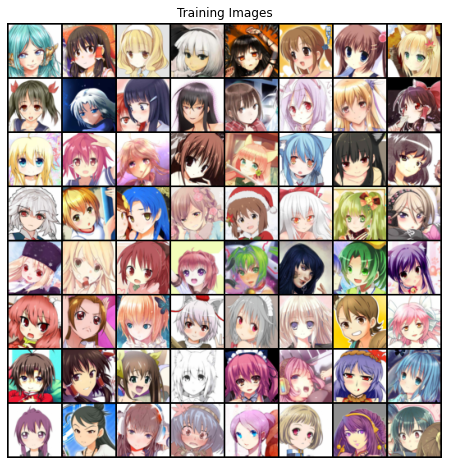

In [24]:
# Create the dataset
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

(a) Construct a DCGAN with GAN objective, you can refer to the tutorial website provided
by PyTorch for implementation.

A:我只使用教學中的Resize,CentorCrop,以及nomarlize而已，分別對訓練資料大小處理，以及從中心做裁減，因為動漫臉的大部分五官都在中間，和將0-255的圖片值轉成0-1。


In [25]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
# Generator 

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)
netG=Generator(ngpu).to(device)
print(netG)
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
# Create the Discriminator
netD = Discriminator(ngpu).to(device)
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)
# Print the model
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [26]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)


# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [27]:
from torch.autograd import Variable
# Training Loop

# Lists to keep track of progress
img_list5 = []
img_list100 = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    t = tqdm(dataloader, ncols=200, bar_format='{l_bar}{bar:15}{r_bar}{bar:-10b}')
    t_desc = "Epoch %3d/%d" % (epoch + 1, num_epochs)
    t.set_description(t_desc)
    for i, data in enumerate(t):
        # D
        netD.zero_grad()
        mini_batch = data[0].to(device)
        bsize = mini_batch.size(0)
        label_real = torch.ones(bsize)
        label_fake = torch.zeros(bsize)
        label_real, label_fake =  Variable(label_real.cuda()), Variable(label_fake.cuda())
        output = netD(mini_batch).view(-1)
        
        D_real_loss = criterion(output, label_real)
        
        noise = torch.randn(bsize, nz, 1, 1, device=device)
        noise = Variable(noise.cuda())
        fake = netG(noise)
        output = netD(fake).view(-1)

        D_fake_loss = criterion(output, label_fake)

        D_train_loss = D_real_loss + D_fake_loss
        D_train_loss.backward()
        
        D_G_z1 = output.mean().item()
        
        optimizerD.step()

        # G
        
        netG.zero_grad()
        noise = torch.randn(bsize, nz, 1, 1, device=device)
        noise = Variable(noise.cuda())
        fake = netG(noise)
        output = netD(fake).view(-1)
        G_train_loss = criterion(output, label_real)
        
        G_train_loss.backward()
        
        D_G_z2 = output.mean().item()
        
        optimizerG.step()
        

        G_losses.append(G_train_loss.item())
        D_losses.append(D_train_loss.item())

        t.set_postfix_str(f"Generator Loss: {G_train_loss.item()}, Discriminator Loss: {D_train_loss.item()}")
        t.update(0)
        # Check how the generator is doing by saving G's output on fixed_noise
        if (epoch==4)and (i == len(dataloader)-1):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list5.append(vutils.make_grid(fake, padding=2, normalize=True))

        elif (epoch==99)and (i == len(dataloader)-1):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list100.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


Epoch 100/100: 100%|███████████████| 79/79 [00:52<00:00,  1.51it/s, Generator Loss: 1.7165637016296387, Discriminator Loss: 0.15018366277217865]                                                        


(b) Plot the learning curves for both generator and discriminator.

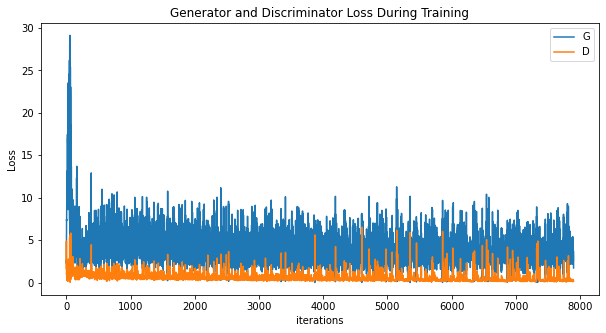

In [40]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

(c) Draw some samples generated from your generator at different training stages.

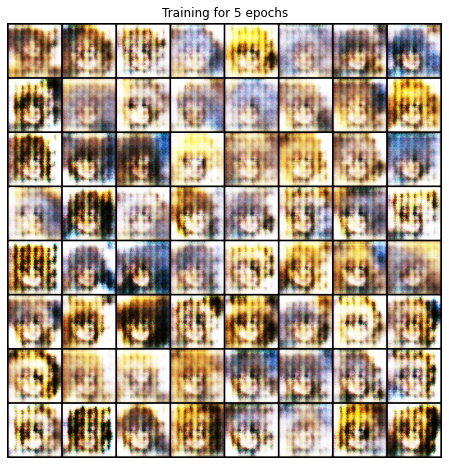

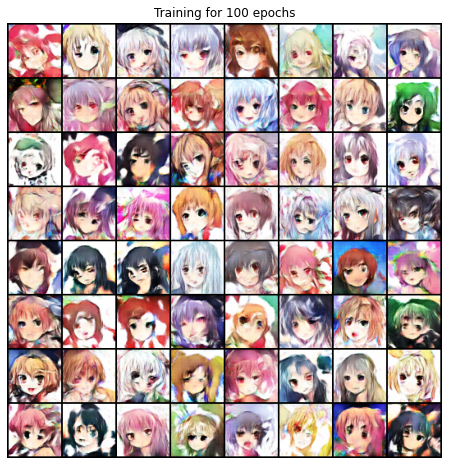

In [39]:
fig5 = plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training for 5 epochs")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list5]


fig100 = plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training for 100 epochs")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list100]

<font color=White size=4 face=雅黑>2. Please answer the following questions in your submission report, you can refer to the
paper to answer these questions.</font>


(a) Please describe the meaning of the following four pictures during training of GAN,
where blue dashed line indicates the discriminator, green solid line indicates the generator. The answer should include the following: (Note: Each step should be discussed.)(10%)


− what is the meaning of black dashed line, x and z


− which step is to train the generator or discriminator and show the corresponding objective function


− why D(x) equals to 1/2 in ideal case when the training is finished


A: 黑色虛線的意思是數據生成分佈px，下面的橫線z是被採樣的domain，在這種情況下是均勻的，上面的橫線x的一部分domain。向上的箭頭表示了映射 x = G(z) 如何將非均勻分佈 pg 轉到變換後的樣本上。

A圖代表一個接近收斂的adversarial pair，pg(綠線)就像是pdata，而D(藍線)是一個部分準確的分類器classifier。

B圖代表在內部迭代，D被訓練而收斂到到pdata(x)/(pdata(x)+pg(x))的位置上。

C圖代表在對G進行更新後，D的gradient導致G(z)移向更有可能被分類為真實數據的區域。

D圖代表經過一些時間的訓練，G和D都有足夠的能力，而這兩條曲線將會重和於pg=pdata，因為D分不出來真假數據的分布，所以D(x)會等於1/2，意味著生成器G已經完美地學習了數據並且可以生成與真實圖像無法區分的圖像，所以判別器基本上是用猜的像是在拋硬幣。

(b) The Helvetica Scenario often happens during training procedure of GAN. Please explain why this problem occurs and how to avoid it. 

A:The Helvetica Scenario表示生成器G將會放棄原先的一些隨機noise，對應生成相同的數據樣本x，導致生成器G對原始數據分佈pdata建模時發生功能坍塌而失去生成多樣性樣本的能力。也就是說生成器開始偷懶了，一直產生同樣的sample，因為這樣就可以騙過分類器了，導致mode collapses。
通常會產生是因為在單個x上設定太多porbability mass，而其中的解決方法為在進入D之前不要讓G訓練太長時間，也就是加強D的訓練，減少G的訓練，使G和D保持同步。或是可以使用不同loss function，如Wasserstein Loss，因為原本的loss function可能會有無意義的梯度。

(c)Both VAE and GAN are generative models. The following figures are random generated results by using VAE (left) and GAN (right). Please compare two results and describe the pros and cons of two models.

A:從圖片上來說，GAN產生的結果較VAE好，而其中最大的差別就是loss，VAE是pointwise loss，一個典型的特徵就是pointwise loss常常會脫離數據流形面，因此看起來生成的圖片會模糊，而GAN是分佈匹配的loss，更能貼近流行面，看起來就會比較清晰，而相較於VAE，GAN訓練的方法只需要使用backward逆向更新，不需要像VAE需要額外訓練一個inference model，所以學習比較容易。而造成VAE模糊的另一原因是因為VAE模型的設計已經強制把分布同步到高斯分布，就一定會造成模糊。